# Prediction Model Comparison Example
This notebook demonstrates how to use the `model_monitoring` module to compare two prediction models, analyzing their performance across different data segments.

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from model_monitoring import (
    AnalysisDataBuilder,
    SegmentCategorical,
    SegmentCustom,
    calculate_statistics,
)
from model_monitoring.plotting import plot_segment_statistics, set_plot_theme

ImportError: cannot import name 'SegmentCategorical' from 'model_monitoring.monitoring' (/home/diego/Dropbox/DropboxGit/VarTester/src/model_monitoring/monitoring.py)

## 1. Generate Synthetic Data

First, we'll create a synthetic dataset. This dataset mimics a typical insurance scenario with multiple coverages, predictions (risk premiums), and observed outcomes (targets/claims). The data is saved to a parquet file.

In [2]:
# --- Create a Synthetic Dataset ---
np.random.seed(42)
n_samples = 10000

# Create some numerical features
features = pd.DataFrame(
    {
        "age": np.random.randint(18, 70, n_samples),
        "income": np.random.gamma(2, 40000, n_samples),
        "credit_score": np.random.randint(300, 850, n_samples),
        "market_premium": np.random.uniform(0.1, 0.5, n_samples),
    }
)

# Create a categorical feature
features["region"] = np.random.choice(
    ["North", "South", "East", "West"], n_samples, p=[0.3, 0.2, 0.25, 0.25]
)

# --- Generate data for N=3 coverages in a wide format ---
N_coverages = 3
df = features.copy()

for i in range(N_coverages):
    cov_suffix = f"_{chr(65 + i)}"  # e.g., _A, _B, _C

    # --- Generate True Risk (rate for Poisson) ---
    true_risk_formula = (
        -4.0
        + (i * 0.1)
        + df["age"] / (20 + i * 2)
        - df["credit_score"] / (500 + i * 20)
        + df["income"] / 100000
    )
    true_risk_index = np.exp(true_risk_formula)

    # --- Generate a Slightly Incorrect Prediction ---
    prediction_formula = (
        -3.9
        + (i * 0.1)
        + df["age"] / (22 + i * 2)
        - df["credit_score"] / (550 + i * 20)
        + df["income"] / 110000
    )
    df[f"prediction{cov_suffix}"] = np.exp(prediction_formula)
    df[f"prediction{cov_suffix}_comp"] = np.exp(
        prediction_formula + 0.1 * +df["age"] / (22 + i * 2)
    )
    # --- Generate Target (claims) from the true risk ---
    df[f"target{cov_suffix}"] = np.random.poisson(true_risk_index)

# Add a single weight column
df["weight"] = 1.0

# Save to parquet
output_path = "../../data/segmentation_data_comp.parquet"
df.to_parquet(output_path)

print(f"Synthetic data generated and saved to {output_path}")
df.head()

Synthetic data generated and saved to ../../data/segmentation_data_comp.parquet


,age,income,credit_score,market_premium,region,prediction_A,prediction_A_comp,target_A,prediction_B,prediction_B_comp,target_B,prediction_C,prediction_C_comp,target_C,weight
0,56,31626.419807,693,0.295256,West,0.097585,0.125872,0,0.091178,0.115140,0,0.087754,0.108845,0,1.0
1,69,94350.676790,565,0.230289,East,0.393303,0.538192,0,0.346978,0.462553,1,0.317891,0.414508,0,1.0
2,46,34226.773664,803,0.112133,South,0.051926,0.064002,0,0.050744,0.061465,0,0.050761,0.060585,0,1.0
3,32,189107.488476,433,0.410269,North,0.220123,0.254587,0,0.221539,0.253137,0,0.226736,0.256432,1,1.0
4,60,32588.089714,325,0.305161,South,0.230528,0.302809,0,0.207231,0.266090,0,0.192646,0.242651,0,1.0


## 2. Configure the Analysis

Now, we set up the analysis by defining the coverages, segmentation strategies, and data treatments.

### Prediction & Target Mapping
We create a dictionary to map each coverage to its corresponding prediction, target, and weight columns.

### Segmentation Strategies
We define how to segment the data. We can create segments from categorical features or by binning numerical features.

In [3]:
segments = [
    # Segment for Age with custom bins
    SegmentCustom(
        seg_col="age",
        seg_name="age_group",
        bins=[18, 30, 45, 60, 75],
        bin_labels=["18-29", "30-44", "45-59", "60+"],
    ),
    # Segment for Income with 5 equal-width bins
    SegmentCustom(seg_col="income", seg_name="income_level", bins=5),
    # Segment for Region (each category is a segment)
    SegmentCategorical(seg_col="region", seg_name="region_segment"),
]
print(f"{len(segments)} segments defined.")

3 segments defined.


### Initialize Analysis and Apply Treatments
We initialize the `AnalysisDataBuilder` object, which orchestrates the data loading, treatment, and segmentation. Treatments are applied to the data, such as isotonic scaling of predictions or aggregating totals.

### Treatment Methods
The `AnalysisDataBuilder` now supports two ways to add treatments:

1. **String-based instantiation** (recommended): Use treatment names as strings - no need to import treatment classes!
2. **Direct class instantiation**: Import and instantiate treatment classes directly (existing approach)

Both methods are equivalent in functionality.

In [4]:
comp_dict = {
    "A": {
        "pred_to_scale": "prediction_A",
        "pred_target": "prediction_A_comp",
        "weight_col": "weight",
        "mask_col": "weight",
        "new_col_name": "prediction_A_scaled",
    }
}

In [5]:
# Initialize AnalysisDataBuilder with the data path
lr_analysis = AnalysisDataBuilder(data=output_path)

# Add treatments - now you can use either string names or direct class instances
lr_analysis.add_treatment("PairwiseIsoResourceScaling", comp_dict)


# Add segments
for s in segments:
    lr_analysis.add_segment(s)

# Load data and apply all defined steps
lr_analysis.load_data()
lr_analysis.apply_treatments()
lr_analysis.apply_segments()

print("Analysis configured. Treated and segmented data is ready.")
lr_analysis.db.head()

Analysis configured. Treated and segmented data is ready.


,prediction_A_comp,prediction_A,weight,age,income,region,prediction_A_scaled,age_group,income_level,region_segment
0,0.125872,0.097585,1.0,56,31626.419807,West,0.124427,45-59,"[220.929, 109734.013)",West
1,0.538192,0.393303,1.0,69,94350.676790,East,0.501484,60+,"[220.929, 109734.013)",East
2,0.064002,0.051926,1.0,46,34226.773664,South,0.066209,45-59,"[220.929, 109734.013)",South
3,0.254587,0.220123,1.0,32,189107.488476,North,0.280670,30-44,"[109734.013, 219247.098)",North
4,0.302809,0.230528,1.0,60,32588.089714,South,0.293937,60+,"[220.929, 109734.013)",South


## 3. Calculate Statistics (KPIs)

With the data prepared, we can now define and calculate our KPIs. We can compute simple statistics for our analysis.

In [6]:
# --- Define Statistics to Calculate ---
func_dict = {
    "aggregations": {
        "prediction_A_scaled": (
            "weighted_mean",
            ["prediction_A_scaled", "weight", "weight"],
        ),
        "prediction_A_comp": (
            "weighted_mean",
            ["prediction_A_comp", "weight", "weight"],
        ),
        "mean_of_ratio": (
            "mean_of_variation_perc",
            ["prediction_A_scaled", "prediction_A_comp", "weight", "weight"],
        ),
        "exposure(k)": (lambda df, e: df[e].sum() / 1000, ["weight"]),
    },
    "post_aggregations": {
        "ratio_of_mean": (
            "variation_perc",
            ["prediction_A_scaled", "prediction_A_comp"],
        ),
        "diff_of_mean": ("-", ["prediction_A_scaled", "prediction_A_comp"]),
    },
}

# Calculate statistics
dict_stats, agg_stats = calculate_statistics(lr_analysis, func_dict, bootstrap=False)

print("--- Overall Statistics ---")
agg_stats

--- Overall Statistics ---


prediction_A_scaled    2.118798e-01
prediction_A_comp      2.118798e-01
mean_of_ratio          4.852235e+00
exposure(k)            1.000000e+01
ratio_of_mean          1.309968e-14
diff_of_mean           2.775558e-17
dtype: float64

Here are the statistics for the `age_group` segment:

In [7]:
dict_stats["age_group"]

,prediction_A_scaled,prediction_A_comp,mean_of_ratio,exposure(k),ratio_of_mean,diff_of_mean,segment
age_group,,,,,,,
18-29,0.067301,0.058876,14.613236,2.241,14.310540,0.008425,age_group
30-44,0.127019,0.118325,7.781321,2.967,7.347472,0.008694,age_group
45-59,0.252099,0.251376,0.709355,2.880,0.287686,0.000723,age_group
60+,0.452440,0.476896,-4.893326,1.912,-5.128068,-0.024456,age_group


## 4. Visualize Segmented KPIs

Finally, we visualize the calculated KPIs. The plotting module is flexible and allows for creating multi-panel reports with different chart types.

### Set Plotting Theme
We can set a consistent theme for all our plots.

In [8]:
set_plot_theme(
    annotation_fontsize=14,
    style="seaborn-v0_8-whitegrid",
    target_color="#1E1D25",
    h_line_style=":",
)

### Generate Visualization Report
We define a list of panels to create a comprehensive report. Each panel can be customized (plot type, colors, etc.). Here we show a report with line plots, confidence interval bands, and a bar chart for exposure.

--- Report for age_group ---


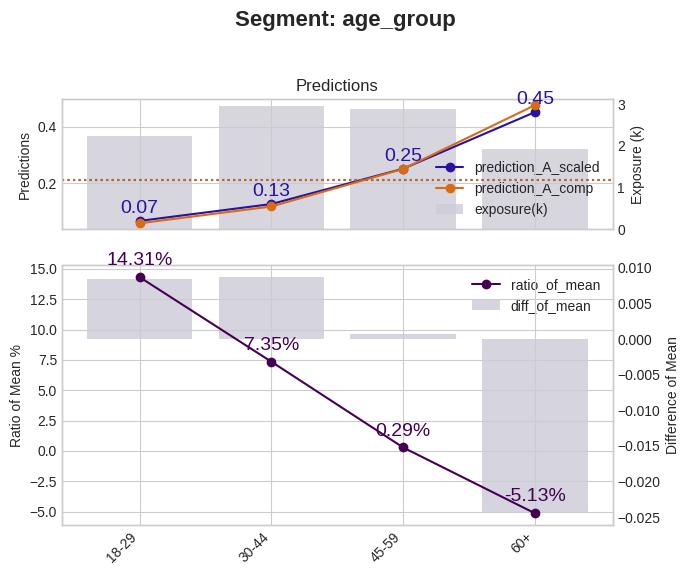

--- Report for income_level ---


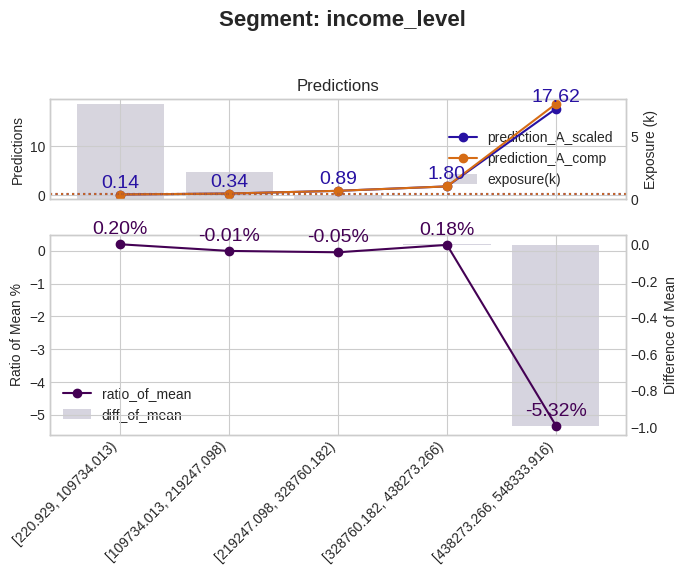

--- Report for region_segment ---


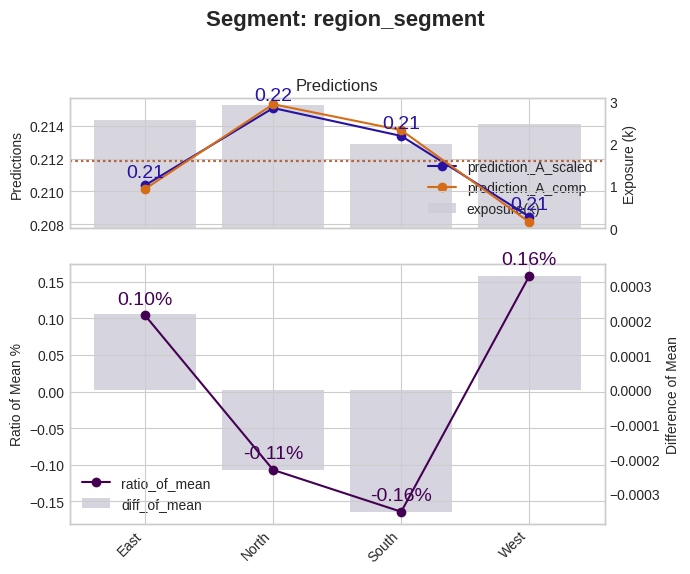

In [9]:
# Define the panels for the plot
report_panels = [
    {
        "title": "Predictions",
        "type": "pred_vs_target",
        "pred_col": ["prediction_A_scaled", "prediction_A_comp"],
        "target_col": None,
        "plot_type": "line",
        "y_label": "Predictions",
        "colors": ["#2812A3", "#D66C15"],
        "show_mean_line": "all",
        "legend_pos": 4,
    },
    {
        "title": "Predictions",  # As the title is reused, this panel will be a twin plot on the same axis
        "type": "exposure",
        "metric_col": "exposure(k)",
        "plot_type": "bar",
        "y_label": "Exposure (k)",
        "colors": ["#CECBD6"],
    },
    {
        "title": "#Evolution",
        "type": "metric",
        "metric_col": ["ratio_of_mean"],
        "plot_type": "line",
        "y_label": "Ratio of Mean %",
    },
    {
        "title": "#Evolution",
        "type": "metric",
        "metric_col": ["diff_of_mean"],
        "plot_type": "bar",
        "colors": ["#CCCAD8"],
        "y_label": "Difference of Mean",
    },
]

# Iterate over each segment's statistics and generate a plot
for segment_name, stats_df in dict_stats.items():
    print(f"--- Report for {segment_name} ---")
    plot_segment_statistics(
        stats_df,
        panel_configs=report_panels,
        agg_stats=agg_stats,
        figure_layout={
            "figsize": (7, 6),
            "nrows": 2,
            "ncols": 1,
            "sharex": True,
            "gridspec_kw": {"height_ratios": [1, 2]},
        },
    )

## 5. Bootstrapped Statistics

Now, let's re-calculate the statistics with bootstrapping enabled to get confidence intervals for our KPIs. This helps in understanding the uncertainty of our metrics.

In [10]:
# --- Recalculate statistics with bootstrapping ---
dict_stats_bs, agg_stats_bs = calculate_statistics(
    lr_analysis,
    func_dict,
    bootstrap=True,
    n_resamples=100,  # Using 100 samples for speed in this example
    ci_level=0.95,
)

print("--- Overall Bootstrapped Statistics (with 95% CI) ---")
agg_stats_bs

--- Overall Bootstrapped Statistics (with 95% CI) ---


prediction_A_scaled_low    2.059985e-01
prediction_A_scaled        2.118798e-01
prediction_A_scaled_up     2.190245e-01
prediction_A_comp_low      2.056004e-01
prediction_A_comp          2.118798e-01
prediction_A_comp_up       2.195777e-01
mean_of_ratio_low          4.715804e+00
mean_of_ratio              4.852235e+00
mean_of_ratio_up           5.007682e+00
exposure(k)_low            1.000000e+01
exposure(k)                1.000000e+01
exposure(k)_up             1.000000e+01
ratio_of_mean_low         -2.548202e-01
ratio_of_mean              1.309968e-14
ratio_of_mean_up           2.072543e-01
diff_of_mean_low          -5.594326e-04
diff_of_mean               2.775558e-17
diff_of_mean_up            4.218005e-04
dtype: float64

Here are the bootstrapped statistics for the `age_group` segment, including confidence intervals.

In [11]:
dict_stats_bs["age_group"]

,segment,prediction_A_scaled_low,prediction_A_scaled,prediction_A_scaled_up,prediction_A_comp_low,prediction_A_comp,prediction_A_comp_up,mean_of_ratio_low,mean_of_ratio,mean_of_ratio_up,exposure(k)_low,exposure(k),exposure(k)_up,ratio_of_mean_low,ratio_of_mean,ratio_of_mean_up,diff_of_mean_low,diff_of_mean,diff_of_mean_up
age_group,,,,,,,,,,,,,,,,,,,
18-29,age_group,0.064541,0.067301,0.069912,0.056436,0.058876,0.061174,14.531104,14.613236,14.680073,2.171950,2.241,2.311575,14.201157,14.310540,14.402672,0.008119,0.008425,0.008741
30-44,age_group,0.123025,0.127019,0.130968,0.114551,0.118325,0.122077,7.711018,7.781321,7.852636,2.874375,2.967,3.058525,7.271086,7.347472,7.418876,0.008419,0.008694,0.008965
45-59,age_group,0.244059,0.252099,0.261092,0.243169,0.251376,0.260553,0.652651,0.709355,0.796134,2.805900,2.880,2.971525,0.183472,0.287686,0.395885,0.000467,0.000723,0.001007
60+,age_group,0.426638,0.452440,0.488625,0.449466,0.476896,0.515672,-4.947194,-4.893326,-4.852387,1.829750,1.912,1.989100,-5.249465,-5.128068,-5.039862,-0.027025,-0.024456,-0.022665


### Visualize Bootstrapped KPIs with Confidence Intervals

Now we can visualize the KPIs with their confidence intervals. The `plot_segment_statistics` function will automatically detect the confidence interval columns and plot them as shaded bands.

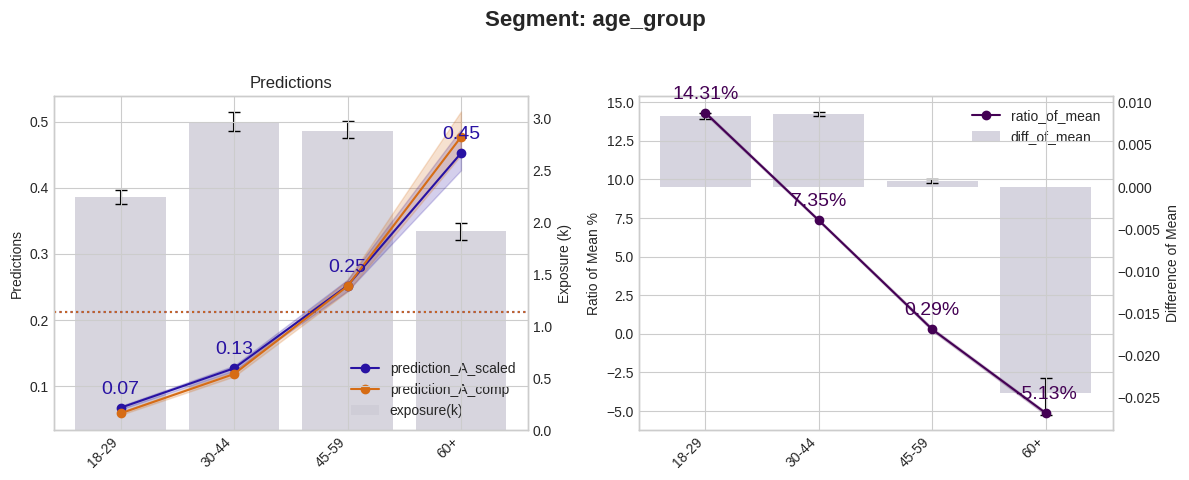

In [12]:
# Create a new report configuration to display confidence intervals
report_panels_bs = [{**panel, "show_ci": True} for panel in report_panels]


plot_segment_statistics(
    dict_stats_bs["age_group"], panel_configs=report_panels_bs, agg_stats=agg_stats_bs
)